IMPORT LIBRARY

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

LOAD DATASET

In [43]:
df = pd.read_csv('Coffe_sales.csv')

print("5 Baris Awal Dataset:")
print(df.head())
print("\nInformasi Tipe Data:")
df.info()

5 Baris Awal Dataset:
   hour_of_day cash_type  money    coffee_name Time_of_Day Weekday Month_name  \
0           10      card   38.7          Latte     Morning     Fri        Mar   
1           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
2           12      card   38.7  Hot Chocolate   Afternoon     Fri        Mar   
3           13      card   28.9      Americano   Afternoon     Fri        Mar   
4           13      card   38.7          Latte   Afternoon     Fri        Mar   

   Weekdaysort  Monthsort        Date             Time  
0            5          3  2024-03-01  10:15:50.520000  
1            5          3  2024-03-01  12:19:22.539000  
2            5          3  2024-03-01  12:20:18.089000  
3            5          3  2024-03-01  13:46:33.006000  
4            5          3  2024-03-01  13:48:14.626000  

Informasi Tipe Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       No

INFO DATA

In [44]:
print("Info Dataset Awal:")
df.info()

Info Dataset Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour_of_day  3547 non-null   int64  
 1   cash_type    3547 non-null   object 
 2   money        3547 non-null   float64
 3   coffee_name  3547 non-null   object 
 4   Time_of_Day  3547 non-null   object 
 5   Weekday      3547 non-null   object 
 6   Month_name   3547 non-null   object 
 7   Weekdaysort  3547 non-null   int64  
 8   Monthsort    3547 non-null   int64  
 9   Date         3547 non-null   object 
 10  Time         3547 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 304.9+ KB


DATA CLEANING 

In [45]:
missing_value = df.isnull().sum()
print(f"\nJumlah Missing Value: \n{missing_value}")

duplicates = df.duplicated().sum()
print(f"\nJumlah baris duplikat: {duplicates}")

df['Date'] = pd.to_datetime(df['Date'])


Jumlah Missing Value: 
hour_of_day    0
cash_type      0
money          0
coffee_name    0
Time_of_Day    0
Weekday        0
Month_name     0
Weekdaysort    0
Monthsort      0
Date           0
Time           0
dtype: int64

Jumlah baris duplikat: 0


VISUALISASI EDA

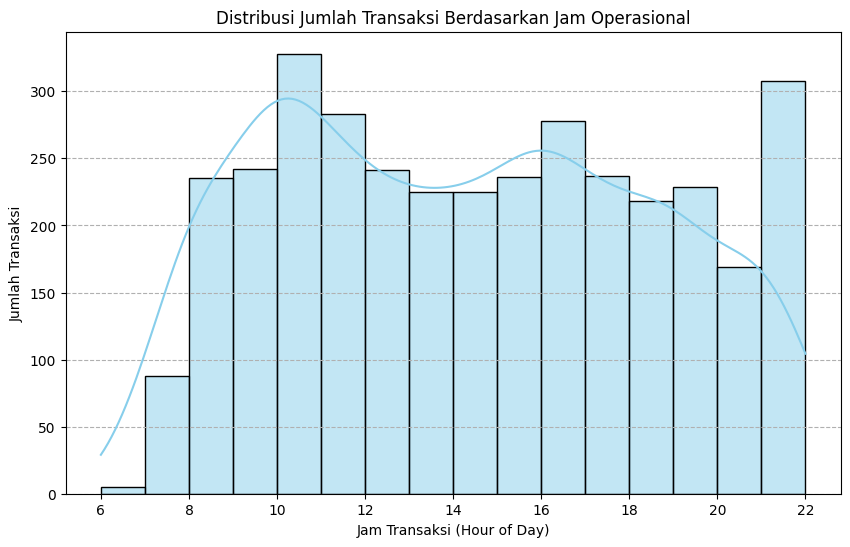

C:\Users\IDEAPAD\AppData\Local\Temp\ipykernel_20508\3903072476.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


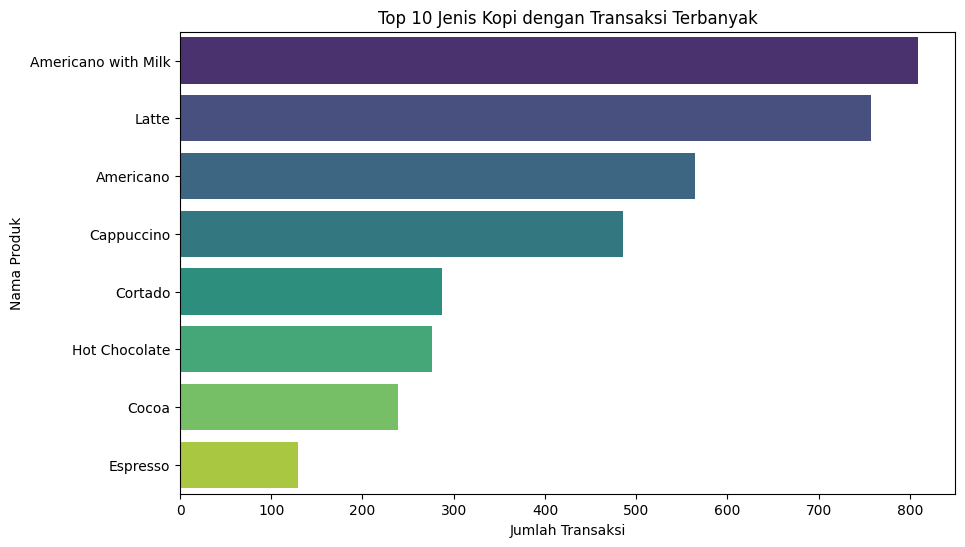

C:\Users\IDEAPAD\AppData\Local\Temp\ipykernel_20508\3903072476.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Weekday', order=day_order_abbr, palette='viridis')


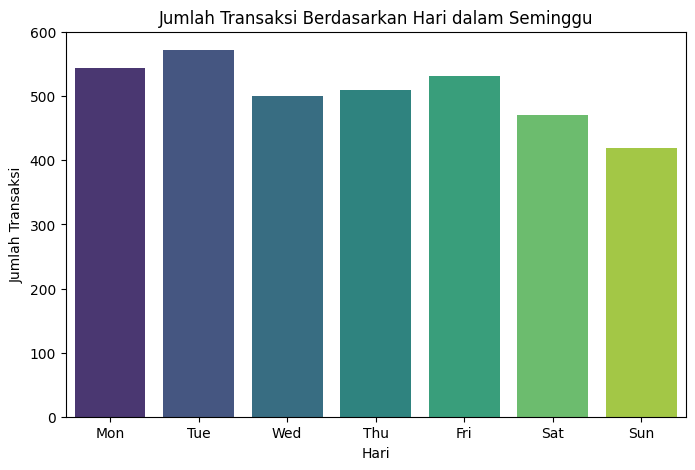

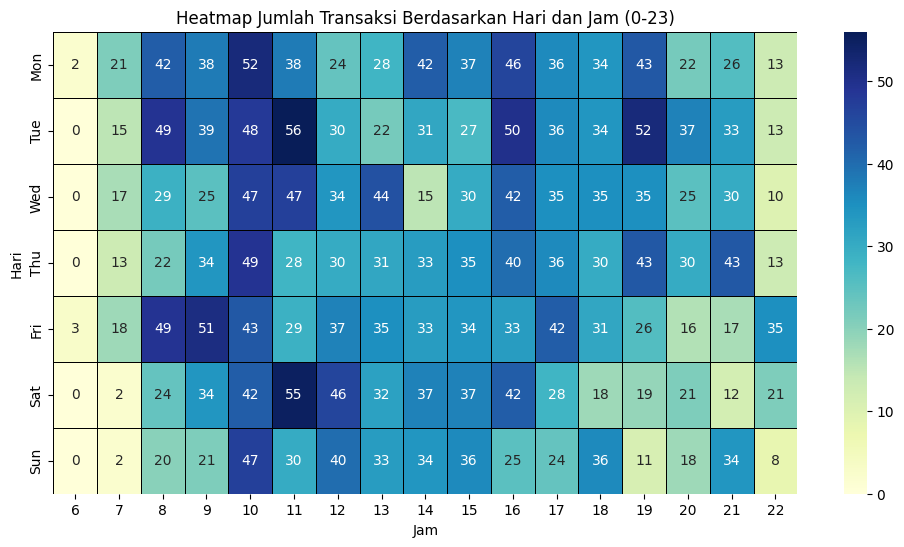

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='hour_of_day', bins=16, kde=True, color='skyblue')
plt.title('Distribusi Jumlah Transaksi Berdasarkan Jam Operasional')
plt.xlabel('Jam Transaksi (Hour of Day)')
plt.ylabel('Jumlah Transaksi')
plt.grid(axis='y', linestyle='--')
plt.show()

plt.figure(figsize=(10, 6))
top_products = df['coffee_name'].value_counts().head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Jenis Kopi dengan Transaksi Terbanyak')
plt.xlabel('Jumlah Transaksi')
plt.ylabel('Nama Produk')
plt.show()

day_order_abbr = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Weekday', order=day_order_abbr, palette='viridis')
plt.title('Jumlah Transaksi Berdasarkan Hari dalam Seminggu')
plt.xlabel('Hari')
plt.ylabel('Jumlah Transaksi')
plt.show()


df_heatmap_hourly = df.groupby(['Weekday', 'hour_of_day']).size().unstack(fill_value=0)

order_day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_heatmap_hourly = df_heatmap_hourly.reindex(order_day)

plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap_hourly, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5, linecolor='black')
plt.title('Heatmap Jumlah Transaksi Berdasarkan Hari dan Jam (0-23)')
plt.ylabel('Hari')
plt.xlabel('Jam')
plt.show()

DATA PREPARATION

In [47]:
df_agg = df.groupby(['Date', 'hour_of_day']).size().reset_index(name='order_count')

threshold = df_agg['order_count'].quantile(0.75)
print(f"Threshold Transaksi untuk Peak Hour: > {int(threshold)} transaksi/jam")

df_agg['is_peak_hour'] = (df_agg['order_count'] > threshold).astype(int)

df_agg['day_of_week_name'] = df_agg['Date'].dt.day_name()
df_agg['month'] = df_agg['Date'].dt.month

print("\nData hasil Agregasi dan Pelabelan:")
print(df_agg.head())

Threshold Transaksi untuk Peak Hour: > 2 transaksi/jam

Data hasil Agregasi dan Pelabelan:
        Date  hour_of_day  order_count  is_peak_hour day_of_week_name  month
0 2024-03-01           10            1             0           Friday      3
1 2024-03-01           12            2             0           Friday      3
2 2024-03-01           13            2             0           Friday      3
3 2024-03-01           15            1             0           Friday      3
4 2024-03-01           16            1             0           Friday      3


ENCODING

In [48]:
le = LabelEncoder()
df_agg['day_code'] = le.fit_transform(df_agg['day_of_week_name'])
print("Hasil Label Encoding untuk Hari:")
print(df_agg[['day_of_week_name', 'day_code']].drop_duplicates().sort_values('day_code'))

Hasil Label Encoding untuk Hari:
   day_of_week_name  day_code
0            Friday         0
18           Monday         1
7          Saturday         2
12           Sunday         3
27         Thursday         4
21          Tuesday         5
25        Wednesday         6


Analisis Korelasi Fitur (Correlation Heatmap) pengaruh paling kuat terhadap `is_peak_hour`.

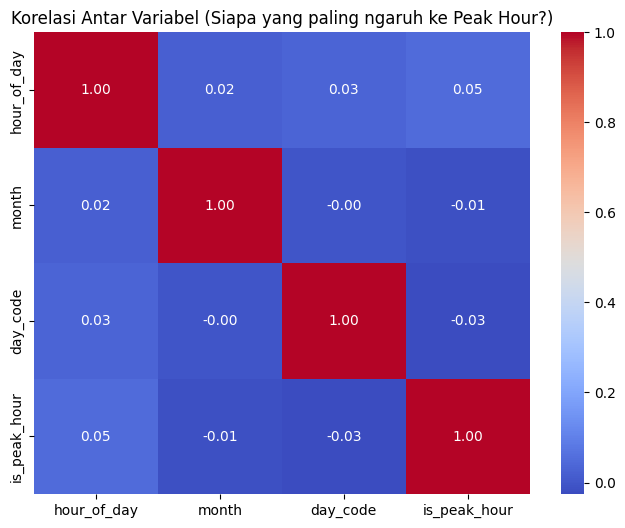

In [49]:
plt.figure(figsize=(8, 6))
# Kita cek korelasi di data yang udah di-agregasi (biar relevan sama target)
sns.heatmap(df_agg[['hour_of_day', 'month', 'day_code', 'is_peak_hour']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Variabel (Siapa yang paling ngaruh ke Peak Hour?)')
plt.show()

DATA SPLITTING

In [50]:
features = ['hour_of_day', 'month', 'day_code']
X = df_agg[features]
y = df_agg['is_peak_hour']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Jumlah Data Training: {X_train.shape[0]} | Jumlah Data Testing: {X_test.shape[0]}")

Jumlah Data Training: 1625 | Jumlah Data Testing: 407


STANDARISASI DATA

In [51]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\nData fitur Training dan Testing sudah di-scale.")


Data fitur Training dan Testing sudah di-scale.


In [52]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("Model Random Forest berhasil dilatih.")

Model Random Forest berhasil dilatih.


AKURASI: 77.15%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       336
           1       0.24      0.14      0.18        71

    accuracy                           0.77       407
   macro avg       0.54      0.52      0.52       407
weighted avg       0.73      0.77      0.75       407



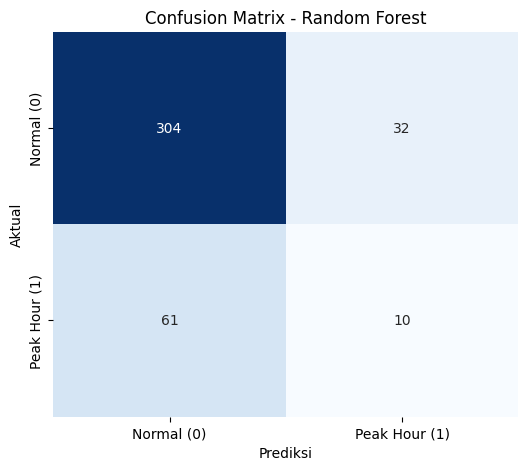

In [53]:
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"AKURASI: {accuracy:.2%}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal (0)', 'Peak Hour (1)'],
            yticklabels=['Normal (0)', 'Peak Hour (1)'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [54]:
from sklearn.naive_bayes import GaussianNB

print("\n" + "="*40)
print(" MULAI KOMPARASI DENGAN NAIVE BAYES ")
print("="*40)

# 1. Inisialisasi & Latih Model Naive Bayes (GaussianNB cocok buat data angka/skala)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# 2. Prediksi
y_pred_nb = nb_model.predict(X_test)

# 3. Evaluasi Naive Bayes
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"AKURASI Naive Bayes: {acc_nb:.2%}")
print("\n--- Classification Report (Naive Bayes) ---")
print(classification_report(y_test, y_pred_nb))

# 4. Head-to-Head: Random Forest vs Naive Bayes
# Asumsi: variabel 'accuracy' nyimpen nilai akurasi RF dari cell sebelumnya
print("\n" + "-"*30)
print(" HASIL AKHIR: RF vs NB ")
print("-"*30)
print(f"Random Forest Accuracy : {accuracy:.2%}")
print(f"Naive Bayes Accuracy   : {acc_nb:.2%}")

if accuracy > acc_nb:
    print("\nKESIMPULAN: Random Forest MENANG! 🎉")
    print("Model ini lebih jago nangkep pola kompleks di data kopi lo.")
else:
    print("\nKESIMPULAN: Naive Bayes MENANG! 😲")
    print("Ternyata model simpel malah lebih gacor.")


 MULAI KOMPARASI DENGAN NAIVE BAYES 
AKURASI Naive Bayes: 82.56%

--- Classification Report (Naive Bayes) ---
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       336
           1       0.00      0.00      0.00        71

    accuracy                           0.83       407
   macro avg       0.41      0.50      0.45       407
weighted avg       0.68      0.83      0.75       407


------------------------------
 HASIL AKHIR: RF vs NB 
------------------------------
Random Forest Accuracy : 77.15%
Naive Bayes Accuracy   : 82.56%

KESIMPULAN: Naive Bayes MENANG! 😲
Ternyata model simpel malah lebih gacor.


C:\Users\IDEAPAD\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\IDEAPAD\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\IDEAPAD\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

FEATURE IMPORTANCE

In [55]:
print("--- Feature Importance ---")

importances = rf_model.feature_importances_
feature_names = X.columns 

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Score': importances
})

feature_importance_df = feature_importance_df.sort_values(
    by='Importance Score', ascending=False
).reset_index(drop=True)

print(feature_importance_df)

--- Feature Importance ---
       Feature  Importance Score
0  hour_of_day          0.471587
1        month          0.340243
2     day_code          0.188170


VISUALISASI FEATURE IMPORTANCE

C:\Users\IDEAPAD\AppData\Local\Temp\ipykernel_20508\2156272138.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


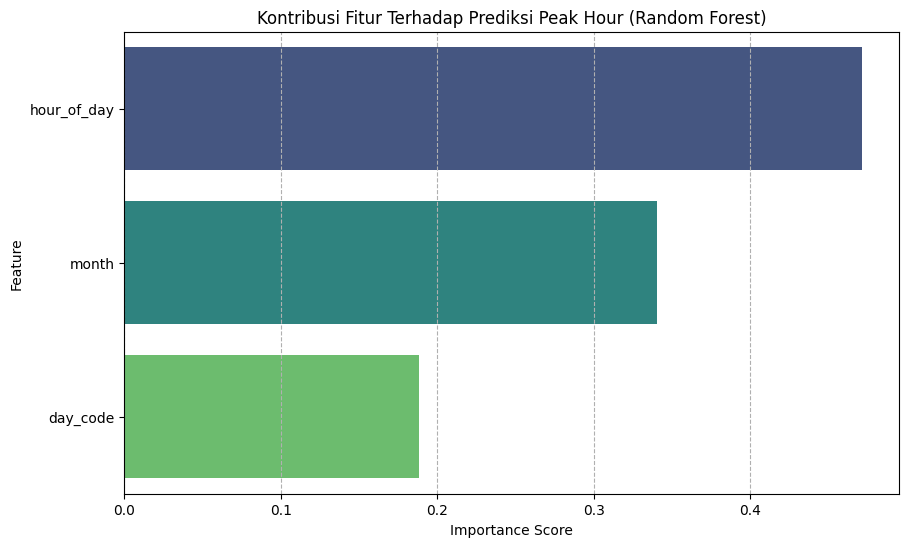

In [56]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance Score',
    y='Feature',
    data=feature_importance_df,
    palette='viridis' 
)
plt.title('Kontribusi Fitur Terhadap Prediksi Peak Hour (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--')
plt.show()